In [1]:
from pandas import DataFrame, read_csv, concat
from csv import reader
from numpy import mean, array, zeros, errstate, seterr, isfinite
from collections import defaultdict
from scipy.spatial.distance import cosine
from scipy.stats import spearmanr
from os import path
from gensim.models import KeyedVectors, Word2Vec
from pymorphy2 import MorphAnalyzer
from itertools import product

morph = MorphAnalyzer()
seterr(all='raise')

Using Theano backend.


{'divide': 'ignore', 'invalid': 'ignore', 'over': 'ignore', 'under': 'ignore'}

In [2]:
# df_en = DataFrame.from_csv('data/eye-tracking/eye_tracking_data_en_raw.csv').reset_index(drop=True)

In [3]:
# df_ru = DataFrame.from_csv('data/eye-tracking/eye_tracking_data_ru.csv')

Load raw messy corpus proposed by the Laboratory of Neurolinguistics and transform it to a decent dataset

In [4]:
# with open(path.join('data', 'data.csv'), mode='r') as infile:
#     corpus_bytes = reader(infile)
#     corpus = [i for i in corpus_bytes]

# corpus = [i[0].split('\t') if len(i) == 1 else ''.join(i).split('\t') for i in corpus]
# df = DataFrame(corpus[1:], columns=corpus[0])

Amount of unique words in a corpus

In [5]:
# len(df['word.id'].unique())

Aggregate corpus data by unqiue words

In [6]:
# df_en = df_en.astype('str').groupby('Word_Cleaned').agg({
#                             'IA_DWELL_TIME': ', '.join,
#                             'IA_FIRST_FIXATION_DURATION': ', '.join,
#                             'IA_FIRST_FIXATION_VISITED_IA_COUNT': ', '.join,
#                             'IA_FIRST_FIXATION_X': ', '.join,
#                             'IA_FIRST_FIXATION_Y': ', '.join,
#                             'IA_FIRST_FIX_PROGRESSIVE': ', '.join,
#                             'IA_FIRST_FIXATION_TIME': ', '.join,
#                             'IA_FIRST_RUN_DWELL_TIME': ', '.join,
#                             'IA_FIRST_RUN_START_TIME': ', '.join,
#                             'IA_FIRST_RUN_END_TIME': ', '.join,
#                             'IA_FIRST_FIXATION_TIME': ', '.join,
#                             'IA_FIRST_RUN_FIXATION_COUNT': ', '.join,
#                             'IA_DWELL_TIME': ', '.join,
#                             'IA_FIXATION_COUNT': ', '.join,
#                             'IA_RUN_COUNT': ', '.join,
#                             'IA_SKIP': ', '.join,
#                             'IA_REGRESSION_IN': ', '.join,
#                             'IA_REGRESSION_IN_COUNT': ', '.join,
#                             'IA_REGRESSION_OUT': ', '.join,
#                             'IA_REGRESSION_OUT_COUNT': ', '.join,
#                             'IA_REGRESSION_OUT_FULL': ', '.join,
#                             'IA_REGRESSION_OUT_FULL_COUNT': ', '.join,
#                             'IA_REGRESSION_PATH_DURATION': ', '.join,
#                             'IA_REGRESSION_OUT_FULL_COUNT': ', '.join,
#                             'IA_REGRESSION_PATH_DURATION': ', '.join,
#                             'IA_FIRST_SACCADE_AMPLITUDE': ', '.join,
#                             'IA_FIRST_SACCADE_ANGLE': ', '.join,
#                             'IA_FIRST_SACCADE_END_TIME': ', '.join,
#                             'IA_FIRST_SACCADE_START_TIME': ', '.join
#                         }).reset_index()

In [7]:
# df = df.groupby('Lemma').agg({
#                             'average.accuracy': ', '.join,
#                             'IA_DWELL_TIME': ', '.join,
#                             'IA_FIRST_FIXATION_DURATION': ', '.join,
#                             'IA_FIRST_RUN_DWELL_TIME': ', '.join,
#                             'IA_FIRST_RUN_FIXATION_COUNT': ', '.join,
#                             'IA_FIXATION_COUNT': ', '.join,
#                             'IA_LEGAL': ', '.join,
#                             'IA_REGRESSION_IN': ', '.join,
#                             'IA_REGRESSION_OUT_FULL': ', '.join,
#                             'IA_REGRESSION_PATH_DURATION': ', '.join,
#                             'IA_SECOND_RUN_DWELL_TIME': ', '.join,
#                             'ao': ', '.join,
#                             'IA_SELECTIVE_REGRESSION_PATH_DURATION': ', '.join,
#                             'IA_SKIP': ', '.join,
#                             'IA_SPILLOVER': ', '.join,
#                             'landing': ', '.join,
#                             'dir': ', '.join,
#                             'fixated.letter': ', '.join,
#                             'one_fix': ', '.join,
#                             'twoplus_fix': ', '.join,
#                             'logit.acc': ', '.join,
#                         }).reset_index()

Serialize transformed dataset

In [8]:
# df_ru.to_csv('data/eye-tracking/eye_tracking_data_ru.csv')
df_ru = DataFrame.from_csv('data/eye-tracking/eye_tracking_data_ru.csv').fillna(',')

In [9]:
# df_en[7:].reset_index(drop=True).to_csv('data/eye-tracking/eye_tracking_data_en.csv')
df_en = DataFrame.from_csv('data/eye-tracking/eye_tracking_data_en.csv').fillna(',')

In [10]:
ru_en_dict = DataFrame.from_csv('data/dictionaries/en-ru-dict.csv')

Calculate mean value of aggregated values for each word in the dataset

In [11]:
def calculate_mean(df, na):
    for column in df:
        for i in range(len(df)):
            try:
                values = list(filter(lambda a: a != na, [a.strip() for a in df[column][i].split(',')]))
                if not values:
                    df[column][i] = 0
                    continue
                df[column][i] = mean([float(a) for a in values])
            except ValueError: # if column is a column of words
                continue 
            except FloatingPointError: # if all are NA
                df[column][i] = 0
    return df

In [12]:
df_en = calculate_mean(df_en, 'nan')
df_ru = calculate_mean(df_ru, 'NA')

Loading and processing dataset of human judgements of embeddings

In [13]:
def load_sim_dataset(name, embeddings, verbose=False):
    df = read_csv(path.join('data', '{}.csv'.format(name))).dropna()
    old_len = len(df)
    for i, m in df.iterrows():
        if not m['word1'] in embeddings or not m['word2'] in embeddings:
            df.drop(i, inplace=True)
    if verbose:
        print('Percent of dropped = {:2.1f}%, amount of remanining words = {}'.format((old_len - len(df))/old_len*100, len(df)))
    return df.reset_index(drop=True)

In [14]:
def make_sims_dataset(dataset, embeddings):
    sims = zeros(shape=len(dataset), dtype='float32')
    for i, m in dataset.iterrows():
        sims[i] = 1 - cosine(embeddings[m['word1']], embeddings[m['word2']])
    return sims

In [15]:
def make_word2vec_dataset(dataset, model):
    sims = zeros(shape=len(dataset), dtype='float32')
    for i, m in dataset.iterrows():
        sims[i] = 1 - cosine(model[add_pos_tag(m['word1'])], model[add_pos_tag(m['word2'])])
    return sims

In [16]:
def make_word2vec_eye_dataset(dataset, model):
    pairs = list(product(dataset, repeat=2))
    sims_w2v = zeros(shape=len(pairs), dtype='float32')
    sims_eye = zeros(shape=len(pairs), dtype='float32')
    for i in enumerate(pairs):
        try:
            sims_w2v[i[0]] = 1 - cosine(model[add_pos_tag(i[1][0])], model[add_pos_tag(i[1][1])])
            sims_eye[i[0]] = 1 - cosine(dataset[i[1][0]], dataset[i[1][1]])
        except KeyError:
            continue
    return sims_w2v, sims_eye

Load Word2Vec-model

In [17]:
rusvectores = KeyedVectors.load_word2vec_format(path.join('..', 'models', 'rusvectores.bin'), binary=True)

In [18]:
def add_pos_tag(word):
    tag = str(morph.parse(word)[0].tag.POS)
    if tag == 'ADJF':
        tag = 'ADJ'
    elif tag == 'INFN':
        tag = 'VERB'
    if word == 'объем': 
        tag = 'NOUN'
    if word == 'струя':
        tag = 'NOUN'
    if word == 'чай':
        tag = 'NOUN'
    if word == 'два':
        word = 'двадцать'
        tag = 'NUM'
    return '{}_{}'.format(word, tag)

Make a comparison

In [19]:
eye_embeddings_en = {}
eye_embeddings_en_ru = {}

for i, k in df_en.iloc[:,0:len(df_en.columns)].iterrows():
    try:
        eye_embeddings_en_ru[ru_en_dict[ru_en_dict['en'] == k['Word_Cleaned']].iloc[0, 1]] = array(k[1:].values)
        eye_embeddings_en[k['Word_Cleaned']] = array(k[1:].values)
    except IndexError: # no such word in the en-ru dict
        continue

In [20]:
eye_embeddings_ru = {}
eye_embeddings_ru_en = {}

for i, k in df_ru.iloc[:,0:len(df_ru.columns)].iterrows():
    try:
        eye_embeddings_ru_en[ru_en_dict[ru_en_dict['ru'] == k['Lemma']].iloc[0, 0]] = array(k[1:].values)
        eye_embeddings_ru[k['Lemma']] = array(k[1:].values)
    except IndexError: # no such word in the en-ru dict
        continue

In [21]:
for name, printed_name in [
                ('human_judgements/ru/simlex999', 'RuSimLex999'),
                ('human_judgements/ru/simlex965', 'RuSimLex965'),
                ('human_judgements/ru/hj', 'HJ: Human Judgements of Word Pairs'),
                # ('human_judgements/ru/rt', 'RT: Synonyms and Hypernyms from the Thesaurus RuThes'), 
                # ('human_judgements/ru/ae2', 'AE: Cognitive Associations from the Sociation.org Experiment'),
                ]:
        print('Dataset: {}'.format(printed_name))
        
        dataset = load_sim_dataset(name, eye_embeddings_ru, True)
        eye_sims_ru = make_sims_dataset(dataset, eye_embeddings_ru)
        print('Correlation with Russian human judgements of Russian gaze vectors: {}'.format(spearmanr(eye_sims_ru, dataset.sim)))
        print()
        
        dataset = load_sim_dataset(name, eye_embeddings_en_ru, True)
        eye_sims_en = make_sims_dataset(dataset, eye_embeddings_en_ru)
        print('Correlation with Russian human judgements of English gaze vectors: {}'.format(spearmanr(eye_sims_en, dataset.sim)))
        print('=================================')
        print()

Dataset: RuSimLex999
Percent of dropped = 99.1%, amount of remanining words = 9
Correlation with Russian human judgements of Russian gaze vectors: SpearmanrResult(correlation=0.46666666666666662, pvalue=0.20538635110581185)

Percent of dropped = 98.7%, amount of remanining words = 13
Correlation with Russian human judgements of English gaze vectors: SpearmanrResult(correlation=-0.40387622927148609, pvalue=0.1711139633176631)

Dataset: RuSimLex965
Percent of dropped = 99.1%, amount of remanining words = 9
Correlation with Russian human judgements of Russian gaze vectors: SpearmanrResult(correlation=0.46666666666666662, pvalue=0.20538635110581185)

Percent of dropped = 98.7%, amount of remanining words = 13
Correlation with Russian human judgements of English gaze vectors: SpearmanrResult(correlation=-0.40387622927148609, pvalue=0.1711139633176631)

Dataset: HJ: Human Judgements of Word Pairs
Percent of dropped = 97.0%, amount of remanining words = 12
Correlation with Russian human judge

In [22]:
for name, printed_name in [
                ('human_judgements/en/wordsim353-rel', 'wordsim353'),
                ]:
        print('{}'.format(printed_name))
        
        dataset = load_sim_dataset(name, eye_embeddings_en, True)
        eye_sims_en = make_sims_dataset(dataset, eye_embeddings_en)
        print('Correlation with English human judgements of English gaze vectors: {}'.format(spearmanr(eye_sims_en, dataset.similarity)))
        print()
        
        dataset = load_sim_dataset(name, eye_embeddings_ru_en, True)
        eye_sims_ru = make_sims_dataset(dataset, eye_embeddings_ru_en)
        print('Correlation with English human judgements of Russian gaze vectors: {}'.format(spearmanr(eye_sims_ru, dataset.similarity)))
        print('=================================')

wordsim353
Percent of dropped = 95.6%, amount of remanining words = 11
Correlation with English human judgements of English gaze vectors: SpearmanrResult(correlation=0.045662100456621002, pvalue=0.8939472667125955)

Percent of dropped = 97.6%, amount of remanining words = 6
Correlation with English human judgements of Russian gaze vectors: SpearmanrResult(correlation=0.52179393208720359, pvalue=0.28834323380039373)


In [23]:
seterr(all='ignore')

{'divide': 'raise', 'invalid': 'raise', 'over': 'raise', 'under': 'raise'}

In [24]:
print('Correlation with Russian gaze vectors of Russian Word2Vec: {}'.format(spearmanr(*make_word2vec_eye_dataset(eye_embeddings_ru, rusvectores))))
print('Correlation with English gaze vectors of Russian Word2Vec: {}'.format(spearmanr(*make_word2vec_eye_dataset(eye_embeddings_en_ru, rusvectores))))

Correlation with Russian gaze vectors of Russian Word2Vec: SpearmanrResult(correlation=0.05731156233054166, pvalue=0.57113821901772477)
Correlation with English gaze vectors of Russian Word2Vec: SpearmanrResult(correlation=0.23347709121972271, pvalue=0.019396284819312579)


Draw plots

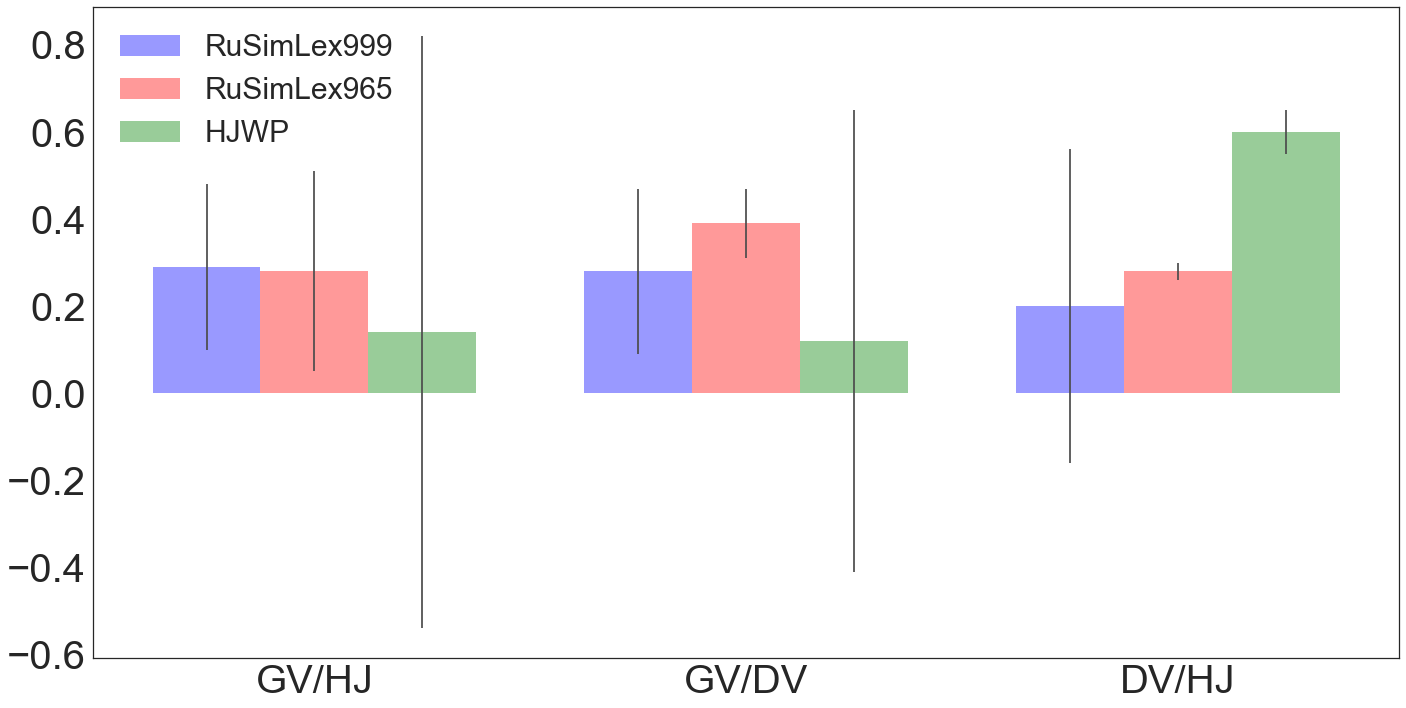

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn 

from pylab import rcParams, axes

rcParams['legend.frameon'] = False
rcParams['figure.figsize'] = 20, 10
rcParams['legend.fontsize'] = 30
rcParams['ytick.labelsize'] = 40
rcParams['xtick.labelsize'] = 40
rcParams['axes.grid'] = False
seaborn.set_style('white')


n_groups = 3

spearman_999 = (0.29, 0.28, 0.2)
pvalue_999 = (0.19, 0.19, 0.36)

spearman_965 = (0.28, 0.39, 0.28)
pvalue_965 = (0.23, 0.08, 0.02)

spearman_hj = (0.14, 0.12, 0.6)
pvalue_hj = (0.68, 0.53, 0.05)

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.25

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = plt.bar(index, spearman_999, bar_width,
                 alpha=opacity,
                 color='b',
                 yerr=pvalue_999,
                 error_kw=error_config,
                 label='RuSimLex999')

rects2 = plt.bar(index + bar_width, spearman_965, bar_width,
                 alpha=opacity,
                 color='r',
                 yerr=pvalue_965,
                 error_kw=error_config,
                 label='RuSimLex965')

rects3 = plt.bar(index + bar_width*2, spearman_hj, bar_width,
                 alpha=opacity,
                 color='g',
                 yerr=pvalue_hj,
                 error_kw=error_config,
                 label='HJWP')

plt.xticks(index + bar_width, ('GV/HJ', 'GV/DV', 'DV/HJ'))
plt.legend()

plt.tight_layout()
plt.show();
plt.savefig('plot.png')